<a href="https://colab.research.google.com/github/Chtholly000/SpeechBrain-implement/blob/main/speechbrainvalid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================
# 0. Install SpeechBrain & helpers (quietly)
# ==============================================================

!pip install -q speechbrain pandas scikit-learn hyperpyyaml tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ==============================================================
# 1. Download Mini-LibriSpeech tutorial + dev-clean subset
# ==============================================================

!wget -q https://www.dropbox.com/s/b61lo6gkpuplanq/MiniLibriSpeechTutorial.tar.gz?dl=0 -O MiniLibriSpeechTutorial.tar.gz
!tar -xzf MiniLibriSpeechTutorial.tar.gz            # gives ./MiniLibriSpeechTutorial/

!wget -q https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xzf dev-clean-2.tar.gz                        # gives ./LibriSpeech/dev-clean-2/


In [ ]:
# ==============================================================
# 2. Parse corpus into a single JSON annotation file
# ==============================================================

# ------------------------------------------------------------------
# Read the JSON and show the first item, no matter the structure
# ------------------------------------------------------------------
import json, itertools

with open(OUT_JSON) as f:
    data = json.load(f)

if isinstance(data, list):
    # Already a list of dicts
    first_rec = data[0]
elif isinstance(data, dict):
    # Dict keyed by utterance IDs → pick first key/value pair
    first_key = next(iter(data))
    first_rec = {"id": first_key, **data[first_key]}
    # If you plan to use pandas / sklearn, convert to list now:
    data_list = [{"id": k, **v} for k, v in data.items()]
else:
    raise TypeError(f"Unexpected JSON root type: {type(data)}")

print("First record:", first_rec)




First record: {'id': '8842-304647-0013', 'file_path': './LibriSpeech/dev-clean-2/8842/304647/8842-304647-0013.flac', 'words': 'THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY', 'spkID': 'speaker_8842', 'length': 142000}


In [ ]:
# ==============================================================
# 3. Split into train / valid JSONs  (dict format for SpeechBrain)
# ==============================================================

import json
from sklearn.model_selection import train_test_split

VALID_FRACTION = 0.10
RANDOM_STATE   = 42

# 1️ load the ORIGINAL dict produced by parse_to_json
with open(OUT_JSON) as f:
    full_dict = json.load(f)            # {utt_id: {...}, ...}

utt_ids = list(full_dict.keys())

# 2️ speaker‑level stratification if tag exists
spk_labels = [full_dict[u].get("speaker_id") for u in utt_ids]
stratify   = spk_labels if None not in spk_labels else None

train_ids, valid_ids = train_test_split(
    utt_ids,
    test_size    = VALID_FRACTION,
    random_state = RANDOM_STATE,
    stratify     = stratify,
)

# 3️ build dicts for each split
train_dict = {u: full_dict[u] for u in train_ids}
valid_dict = {u: full_dict[u] for u in valid_ids}

# 4️ save
json.dump(train_dict, open("train.json", "w"), indent=2)
json.dump(valid_dict, open("valid.json", "w"), indent=2)
print(f"✅ Split created → train.json ({len(train_dict)})  valid.json ({len(valid_dict)})")


✅ Split created → train.json (980)  valid.json (109)


In [ ]:
# ==============================================================
# 4. Build DynamicItemDatasets with an audio pipeline
# ==============================================================

import speechbrain as sb
from speechbrain.dataio.dataset import DynamicItemDataset
from speechbrain.dataio.dataio  import read_audio

# --------------------------------------------------------------
# ⛳  SET THESE to match your keys
# --------------------------------------------------------------
AUDIO_KEY = "file_path"   # audio path
TEXT_KEY  = "words"       # transcript (unused in speaker‑ID task)
SPK_KEY   = "spkID"       # speaker label


@sb.utils.data_pipeline.takes(AUDIO_KEY)
@sb.utils.data_pipeline.provides("signal")
def audio_pipeline(path):
    return read_audio(path)

train_data = DynamicItemDataset.from_json("train.json")
train_data.add_dynamic_item(audio_pipeline)
train_data.set_output_keys(["signal", AUDIO_KEY, TEXT_KEY])

valid_data = DynamicItemDataset.from_json("valid.json")
valid_data.add_dynamic_item(audio_pipeline)
valid_data.set_output_keys(["signal", AUDIO_KEY, TEXT_KEY])

# sanity check
print("\n🧪  Sample train utterance:")
ex = train_data[0]
print("audio :", ex[AUDIO_KEY])
print("shape :", ex["signal"].shape)
print("text  :", ex[TEXT_KEY])



🧪  Sample train utterance:
audio : ./LibriSpeech/dev-clean-2/2428/83699/2428-83699-0019.flac
shape : torch.Size([78560])
text  : THERE WAS A TRAP AT THE BOY AND BLUNDERBUSS BUT THAT REQUIRED FETCHING


INFO:speechbrain.core:Gradscaler enabled: `False`
INFO:speechbrain.core:Using training precision: `--precision=fp32`
INFO:speechbrain.core:Using evaluation precision: `--eval_precision=fp32`
INFO:speechbrain.core:SimpleBrain Model Statistics:
* Total Number of Trainable Parameters: 23.8k
* Total Number of Parameters: 23.8k
* Trainable Parameters represent 100.0000% of the total size.
100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch 0 — valid loss: 2.9311


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch 1 — valid loss: 2.0859


100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch 2 — valid loss: 1.6141


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch 3 — valid loss: 1.3769


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch 4 — valid loss: 0.9645


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch 5 — valid loss: 0.9357


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch 6 — valid loss: 0.6858


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 7 — valid loss: 0.6216


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Epoch 8 — valid loss: 0.4662


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 9 — valid loss: 0.3418


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch 10 — valid loss: 0.5133


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch 11 — valid loss: 0.3006


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch 12 — valid loss: 0.2924


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch 13 — valid loss: 0.2219


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch 14 — valid loss: 0.2091


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch 15 — valid loss: 0.1135


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 16 — valid loss: 0.1312


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Epoch 17 — valid loss: 0.0858


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


Epoch 18 — valid loss: 0.0650


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch 19 — valid loss: 0.1079


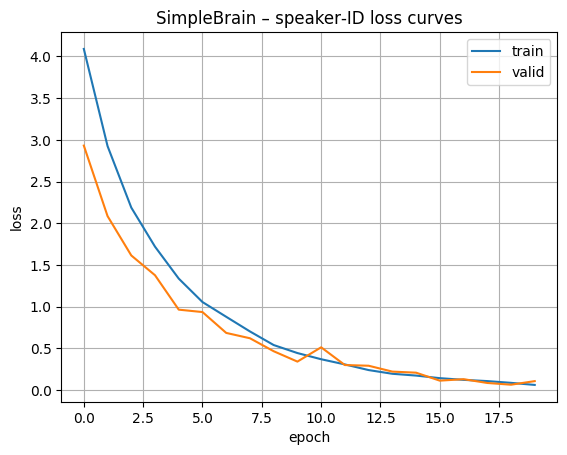

In [ ]:
# ==============================================================
# 5. Model, training loop, and loss‑curve plot
# ==============================================================

import torch, matplotlib.pyplot as plt
import speechbrain as sb
from speechbrain.dataio.dataloader import SaveableDataLoader
from speechbrain.dataio.encoder    import CategoricalEncoder
from speechbrain.lobes.features    import Fbank
from speechbrain.nnet.pooling      import StatisticsPooling
import torch.nn.functional as F
from speechbrain.dataio.batch import PaddedBatch   # already imported
# --------------------------------------------------------------
# Keys that match your JSON
# --------------------------------------------------------------
AUDIO_KEY = "file_path"
TEXT_KEY  = "words"     # (unused here)
SPK_KEY   = "spkID"

# 1️⃣  Speaker‑ID encoder  --------------------------------------
spk_encoder = CategoricalEncoder()
spk_encoder.update_from_didataset(train_data, SPK_KEY)

@sb.utils.data_pipeline.takes(SPK_KEY)          # SPK_KEY = "spkID"
@sb.utils.data_pipeline.provides("spk_encoded")
def encode_spk(spk_id):
    # shape [1]  int64  -> PaddedBatch stacks into [B,1] int64
    return torch.tensor([spk_encoder.encode_label(spk_id)], dtype=torch.long)


train_data.add_dynamic_item(encode_spk)
valid_data.add_dynamic_item(encode_spk)

train_data.set_output_keys(["signal", "spk_encoded"])
valid_data.set_output_keys(["signal", "spk_encoded"])

train_loader = SaveableDataLoader(
    train_data,
    batch_size=16,
    shuffle=True,
    collate_fn=PaddedBatch,    # ← restore this
    drop_last=True,
)
valid_loader = SaveableDataLoader(
    valid_data,
    batch_size=16,
    shuffle=False,
    collate_fn=PaddedBatch,    # ← restore this
)

# 2️⃣  Network modules  -----------------------------------------
N_MELS   = 40

modules = {
    "features" : Fbank(n_mels=N_MELS),              # handles list input
    "encoder"  : torch.nn.Sequential(
                    torch.nn.Linear(N_MELS, 256),
                    torch.nn.ReLU()),
    "pooling"  : StatisticsPooling(),               # → 512 (mean+std)
    "to_output": torch.nn.Linear(512, len(spk_encoder)),
}

# 3️⃣  Brain subclass  ------------------------------------------
class SimpleBrain(sb.Brain):
    def __init__(self, modules, **kwargs):
        super().__init__(modules, **kwargs)
        self.train_loss, self.valid_loss = [], []

    def compute_forward(self, batch, stage):
        wavs, wav_lens = batch.signal.data, batch.signal.lengths

        feats  = self.modules.features(wavs)              # [B, T, 40]
        feats  = self.modules.encoder(feats)              # [B, T, 256]
        feats  = self.modules.pooling(feats, wav_lens)    # [B, 1, 512]
        feats  = feats.squeeze(1)                         # ← drop the 1‑dim  ➜ [B, 512]
        logits = self.modules.to_output(feats)            # [B, 26]
        return logits                                         # raw scores

    def compute_objectives(self, predictions, batch, stage):
        # --------------------------------------------------------
        # 1)  Collapse the trailing dim that PaddedBatch introduces
        # 2)  Cast to int64  (class indices)
        # 3)  Move to the same device as predictions
        # --------------------------------------------------------
        target = (
            batch.spk_encoded.data.squeeze(-1)          # [B]
            .to(dtype=torch.long, device=predictions.device)
        )


        # Uncomment once to verify shape & dtype:
        # if stage == sb.Stage.TRAIN and self.step == 0:
        #     print("pred:", predictions.shape, predictions.dtype)
        #     print("tgt :", target.shape, target.dtype)
        return F.cross_entropy(predictions, target)


    def on_stage_end(self, stage, stage_loss, epoch):
        if stage == sb.Stage.TRAIN:
            self.train_loss.append(stage_loss)
        elif stage == sb.Stage.VALID:
            self.valid_loss.append(stage_loss)
            # 👈 print validation loss every epoch
            print(f"Epoch {epoch} — valid loss: {stage_loss:.4f}")
brain = SimpleBrain(modules, opt_class=lambda p: torch.optim.SGD(p, lr=0.01))

# 4️⃣  Train -----------------------------------------------------
brain.fit(range(20), train_loader, valid_loader)

# 5️⃣  Plot loss curves -----------------------------------------
plt.plot(brain.train_loss,  label="train")
plt.plot(brain.valid_loss,  label="valid")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
plt.title("SimpleBrain – speaker‑ID loss curves")
plt.grid(True)
plt.show()
